# Exploratory NLP on chat messages in pilot data


-------------------------
Spacy lemmatizer, numbers to text

Calculate new column (prop of L specifc over all words in rep)

Proportion of "L" specific words in LP and LC (i.e. changing the denominator to only be towersets with L) -- then average for each dyad across the two towers

Also column for raw count of L specifc words

plot histogram of differences between rep 0 and rep 3



In [1]:
#!pip install spacy

## Import packages

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt
import spacy

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [12]:
df_chat = pd.read_csv('df_chat.csv')
print(df_chat.shape)
print("Dyads:",len(df_chat.gameid.unique()))

(3066, 21)
Dyads: 71


### Check exclusion criteria

In [17]:
df_trial = pd.read_csv('df_trial.csv')
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 48


### Remove dyads that did not pass exclusion criteria

In [18]:
keep_id = df75.index.tolist()
keep_id
df = df_chat[df_chat['gameid'].isin(keep_id)]
print(df.shape)
print("Passed Dyads:",len(df.gameid.unique()))

(2223, 21)
Passed Dyads: 48


In [19]:
df = df[['gameid','repNum','content','trialNum', 'leftTarget', 'rightTarget']]
df = df[df.trialNum != 'practice']
df = df[df.repNum != 'practice']
df['repNum'] = df['repNum'].astype(int)
df['C'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'C' in x   else 0)
df['L'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'L' in x   else 0)
df['P'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'Pi' in x   else 0)
df = df.drop(['leftTarget', 'rightTarget'],axis = 1)
df.head(2)


,gameid,repNum,content,trialNum,C,L,P
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,put a blue block three from the left~~~,0,1,0,1
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,place a red block on top of the left side of the blue block and then another red on top of that red,0,1,0,1


In [20]:
df['BOW_clean'] = df['content'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\'", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\:", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'"', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"-", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"/", ' ')
df['BOW_clean'] = df['BOW_clean'].str.replace(r".", ' ')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"!", ' ')

In [21]:
import num2words
from num2words import num2words
def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

In [22]:
df['BOW_clean'] = df['BOW_clean'].apply(lambda x: num_2_words(x))

In [23]:
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm")
df['noun_phrases'] = df['BOW_clean'].apply(lambda x: [chunk.text for chunk in nlp(x).noun_chunks])
df.head()

,gameid,repNum,content,trialNum,C,L,P,BOW_clean,noun_phrases
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,put a blue block three from the left~~~,0,1,0,1,put a blue block three from the left,"[a blue block, the left]"
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,place a red block on top of the left side of the blue block and then another red on top of that red,0,1,0,1,place a red block on top of the left side of the blue block and then another red on top of that red,"[a red block, top, the left side, the blue block, then another red, top, that red]"
4,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,Now place a blue block on top of that that lines up with the bottom blue block,0,1,0,1,now place a blue block on top of that that lines up with the bottom blue block,"[a blue block, top, that lines, the bottom blue block]"
5,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,"remove that last blue block, place it on top of the red blocks",0,1,0,1,remove that last blue block place it on top of the red blocks,"[it, top, the red blocks]"
6,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,place a red block on the second grid from the right of the screen\n,0,1,0,1,place a red block on the second grid from the right of the screen,"[a red block, the second grid, the right, the screen]"


## Create Bag of Words for each repNum by concatenating content
create df with column for repnum and column for entire string grouped by repnum

In [24]:
# df['BOW'] = df[['repNum','C','L','Pi','content']].groupby(['repNum','C','L','Pi'])['content'].transform(lambda x: ' '.join(x))
# df = df[['repNum','C','L','Pi','BOW']]
df = df.groupby(['gameid','repNum','C','L','P'])['noun_phrases'].apply(sum).reset_index()
# df['instructions'] = df.groupby(['gameid','repNum','C','L','P'])['noun_phrases'].apply(lambda x: ' '.join(x)).reset_index()
df['np_bow'] = df['noun_phrases'].apply(lambda x: ' '.join(x))
print(df.shape)
df.head(2)

(576, 7)


,gameid,repNum,C,L,P,noun_phrases,np_bow
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"[ two blue blocks, left and right side, left right line, two red block, top, left blue block, right line, one blue block, top red block, left red line, more red block, top, left red block]",two blue blocks left and right side left right line two red block top left blue block right line one blue block top red block left red line more red block top left red block
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"[left red line place blue block, the middle, two red, left side, that blue block, left red line place blue block, highest red, it, the right side, that line, step, the left side, two spaces, those two red blocks, right red line place, one blue block, top, each red block, the blue blocks, touch]",left red line place blue block the middle two red left side that blue block left red line place blue block highest red it the right side that line step the left side two spaces those two red blocks right red line place one blue block top each red block the blue blocks touch


## Isolate words for specific tower within rep and within dyad

In [25]:
#ISOLATE TOWER 1
target_tower = 'L'
tower2 = 'C'
tower3 = 'P'

reps = [0,3]
gameids = df['gameid'].unique()
results = []
for game in gameids:
    for rep in reps:
        target_words_1 = df.loc[(df[target_tower] == 1) & (df[tower2] == 1) & (df['gameid'] == game), 'np_bow'].iloc[rep].split()
        target_words_2 = df.loc[(df[target_tower] == 1) & (df[tower3] == 1) & (df['gameid'] == game), 'np_bow'].iloc[rep].split()
        non_target_words = df.loc[(df[tower2] == 1) & (df[tower3] == 1) & (df['gameid'] == game), 'np_bow'].iloc[rep].split()
        
        total_words = set(target_words_1 + target_words_2 + non_target_words)
        total_target_words = set(target_words_1 + target_words_2)
        
        target_specific_1 = list(set(target_words_1) - set(non_target_words))
        target_specific_2 = list(set(target_words_2) - set(non_target_words))
        specific_words = list(set(target_specific_1) & set(target_specific_2))


        results.append([game, rep, target_tower, specific_words, len(total_target_words),len(total_words)])
  
  
# # Create the pandas DataFrame  
df_intersection = pd.DataFrame(results, columns = ['gameid', 'repNum','tower','tower_specific_words', 'tower_total_words','rep_total_words'])

df_intersection['tower_specific_length'] = df_intersection['tower_specific_words'].apply(lambda x: len(x))
df_intersection['tower_specific_prop'] = df_intersection['tower_specific_length'] / df_intersection['rep_total_words']
print(df_intersection.shape)
df_intersection.tail(2)


(96, 8)


,gameid,repNum,tower,tower_specific_words,tower_total_words,rep_total_words,tower_specific_length,tower_specific_prop
94,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,0,L,[other],27,32,1,0.03125
95,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,L,"[reds, edge]",23,25,2,0.08000


### plot histogram of change in prop of tower-specific words

In [26]:
diffs = []
for game in df_intersection.gameid.unique():
    diffs.append(df_intersection.loc[(df_intersection['gameid'] == game), 'tower_specific_prop'].iloc[1] - 
                df_intersection.loc[(df_intersection['gameid'] == game), 'tower_specific_prop'].iloc[0])

In [27]:
print(len(diffs))
pos = [element for element in diffs if element>0]
print(len(pos))

48
22


In [58]:
diffs

[0.0,
 0.0,
 -0.043243243243243246,
 0.030303030303030304,
 0.034482758620689655,
 0.0,
 -0.07692307692307693,
 -0.046511627906976744,
 0.017045454545454544,
 -0.07692307692307693,
 -0.07692307692307693,
 0.08333333333333333,
 -0.1111111111111111,
 0.058333333333333334,
 -0.08333333333333334,
 -0.07407407407407407,
 0.19281045751633985,
 0.13333333333333333,
 0.0,
 -0.03333333333333333,
 0.1021505376344086,
 -0.05555555555555555,
 0.1865079365079365,
 -0.24324324324324326,
 0.125,
 -0.08108108108108109,
 -0.026455026455026454,
 -0.10185185185185185,
 -0.013888888888888888,
 0.11666666666666665,
 -0.007246376811594207,
 0.013095238095238094,
 -0.09523809523809523,
 0.03968253968253968,
 0.03525641025641026,
 0.11960132890365448,
 0.125,
 0.08717948717948719,
 -0.11428571428571428,
 0.19809523809523807,
 -0.06481481481481481,
 0.009153318077803202,
 0.05952380952380952,
 nan,
 -0.07692307692307693,
 0.0,
 0.020155038759689922,
 0.04875]

In [59]:
np.mean(diffs)

nan

/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


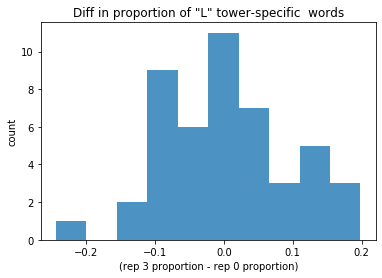

In [28]:
data = diffs

# fixed bin size

plt.hist(data, alpha=0.8)
plt.title('Diff in proportion of "L" tower-specific  words')
plt.xlabel('(rep 3 proportion - rep 0 proportion)')
plt.ylabel('count')

plt.show()

In [24]:
s = df_intersection[df_intersection['repNum'] == 3]['tower_specific_words']
l = [element for list_ in s for element in list_]
counts = Counter(l)
print(len(counts.keys()))
counts.most_common()[:5]


53


[('C', 13), ('blue', 4), ('red', 4), ('third', 3), ('top', 3)]

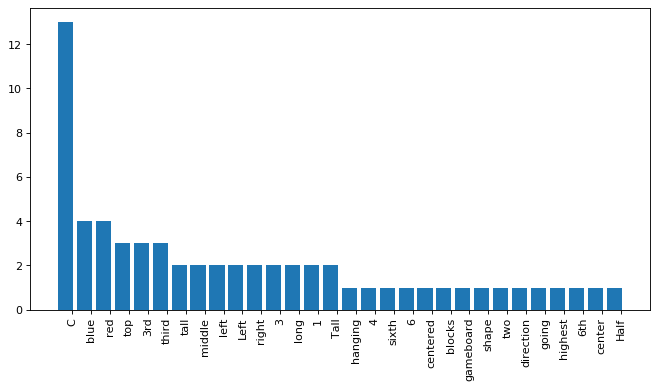

In [25]:
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 30

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()